## Models used to find word embeddings:
1. CBOW : Predicts target word from its surrounding words
2. Skip-Gram : Predicts surrounding words of the target word.

Skip-Gram treats each context-pair as a new observation which has been found to be better when working with larger datasets.
The Skip-Gram implementation for finding Word Embeddings has been illustrated below along with comments to help in understanding the code.

Credits: https://www.tensorflow.org/tutorials/representation/word2vec

In [1]:
import os
import collections
import random
import math
import numpy as np
import tensorflow as tf
from six.moves import xrange
import mlflow

In [5]:
class Word2Vec:
    def __init__(self,filename
                 , vocabulary_size=50000
                 , batch_size=128
                 , skip_window=1
                 , num_skips=2
                 , embedding_size = 128
                 , num_sampled = 64
                 , num_steps = 100001
                ):
        self.filename = filename
        self.vocabulary_size = vocabulary_size
        self.data_index = 0
        self.batch_size = batch_size
        self.skip_window = skip_window  # Number of words to consider left and right.
        self.num_skips = num_skips # Number of times to reuse a window to generate a label
        # self.embedding_size is the length of the word vector, empirically it should be in range [50, 2000].
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled  # Number of negative examples to sample.
        self.num_steps = num_steps # Number of steps the model will be trained for.
        # The below is only for displaynig model accuracy, remove this in production.
        # We pick a random validation set to sample nearest neighbors. 
        # Here we limit the validation samples to the words that have a low numeric ID, which by construction are also the most frequent. 
        # These 3 variables are used only for displaying model accuracy, they don't affect calculation.
        self.valid_size = 16  # Random set of words to evaluate similarity on.
        self.valid_window = 100  # Only pick samples in the head of the distribution.
        self.valid_examples = np.random.choice(self.valid_window, self.valid_size, replace=False)

    def run(self):
        self.load_vocabulary()
        self.build_dataset()
        self.build_model()
        self.train_model()

    def load_vocabulary(self):
        self.vocabulary = []
        f = open(self.filename, 'r')
        for l in f.readlines():
            for r in l.split(" "):
                if r.strip() == "":
                    continue
                self.vocabulary.append(r)
        f.close()
        print('Success: Loaded Vocabulary.')
        print('Vocabulary size :', len(self.vocabulary))

    def build_dataset(self):
        # Compose count (a list of lists which maps top n words to their frequencies in a descending fashion)
        count = [['UNK', -1]]
        count.extend(collections.Counter(self.vocabulary).most_common(self.vocabulary_size - 1))
        dictionary = {}
        # Compose dictionary (a one-to-one mapping of words to some integer)
        for word, _ in count:
            dictionary[word] = len(dictionary)
        data = []
        unk_count = 0
        # Compose data (a list of integers (corresponding to the each word in vocabulary))
        for word in self.vocabulary:
            index = dictionary.get(word, 0)
            # If index equals zero, then its a rare word(UNK).
            if index == 0:
                unk_count += 1
            data.append(index)
        # Update the frequency of rare words(UNK) from -1.
        count[0][1] = unk_count
        # Compose reversed_dictionary ( a one-to-one mapping of integer codes to their string representation(words))
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        self.data = data
        self.count = count
        self.dictionary = dictionary
        self.reverse_dictionary = reverse_dictionary
        print('Success: Built Dataset.')

    def generate_batch(self):
        assert self.batch_size % self.num_skips == 0
        assert self.num_skips <= 2 * self.skip_window
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        # Compute the length/span of the scanning window [ self.skip_window target self.skip_window ]
        span = 2 * self.skip_window + 1
        buffer = collections.deque(maxlen=span)
        # Reset the data_index to zero if the scanning window has reached the end of vocabulary.
        if self.data_index + span > len(self.data):
            self.data_index = 0
        buffer.extend(self.data[self.data_index:self.data_index + span])
        # Update the data_index value so that it points to end of scanning window.
        self.data_index += span
        for i in range(self.batch_size // self.num_skips):
            # Get the indexes for outer context_words surronding the center word.
            context_words = [w for w in range(span) if w != self.skip_window]
            # Select a sub sample of the 'numm_skips' words to be used from the context_words.
            words_to_use = random.sample(context_words, self.num_skips)
            for j, context_word in enumerate(words_to_use):
                batch[i * self.num_skips + j] = buffer[self.skip_window]
                labels[i * self.num_skips + j, 0] = buffer[context_word]
            # Shift the scanning window to the right by inserting element pointed by data_index.
            if self.data_index == len(self.data):
                buffer.extend(self.data[0:span])
                self.data_index = span
            else:
                buffer.append(self.data[self.data_index])
                self.data_index += 1
        # Adjust data_index by 'span' so that no words are skipped.
        self.data_index = (self.data_index + len(self.data) - span) % len(self.data)
        # batch(row vector) contains the 'self.batch_size' number of integer ids(context words)
        # labels(column vector) contain the integer ids for the center/target words
        return batch, labels

    def build_model(self):
        graph = tf.Graph()
        with graph.as_default():
            # Input data.
            with tf.name_scope('inputs'):
                self.train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
                self.train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
                valid_dataset = tf.constant(self.valid_examples, dtype=tf.int32)
            # Ops and variables pinned to the CPU because of missing GPU implementation
            with tf.device('/cpu:0'):
                # Look up embeddings for inputs.
                with tf.name_scope('embeddings'):
                    embeddings = tf.Variable(tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0))
                    # We need to look up the embeddings corresponding to the integer ids in the training inputs.
                    embed = tf.nn.embedding_lookup(embeddings, self.train_inputs)
                # Construct the variables for the NCE loss
                with tf.name_scope('weights'):
                    nce_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size, self.embedding_size], stddev=1.0 / math.sqrt(self.embedding_size)))
                with tf.name_scope('biases'):
                    nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))

            # Define the loss as average NCE loss for the batch.
            # tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss.
            # Explanation of the meaning of NCE loss: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                                                     labels=self.train_labels, inputs=embed,
                                                     num_sampled=self.num_sampled, num_classes=self.vocabulary_size))
            # Construct the SGD optimizer using a learning rate of 1.0.
            with tf.name_scope('optimizer'):
                self.optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(self.loss)
            # Compute the cosine similarity between minibatch examples and all embeddings.
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
            self.normalized_embeddings = embeddings / norm
            valid_embeddings = tf.nn.embedding_lookup(self.normalized_embeddings, valid_dataset)
            self.similarity = tf.matmul(valid_embeddings, self.normalized_embeddings, transpose_b=True)
            # Add variable initializer.
            init = tf.global_variables_initializer()
        self.graph = graph
        self.init = init
        print('Success: Built Model.')

    def train_model(self):
        self.log_to_mlflow()
        with tf.Session(graph=self.graph) as session:
            # We must initialize graph variables before we use them.
            self.init.run()
            print('Initialized Model.')
            average_loss = 0
            for step in xrange(self.num_steps):
                batch_inputs, batch_labels = self.generate_batch()
                feed_dict = {self.train_inputs: batch_inputs, self.train_labels: batch_labels}
                _, loss_val = session.run([self.optimizer, self.loss], feed_dict=feed_dict)
                mlflow.log_metric('loss', loss_val)
                average_loss += loss_val
                if step % 2000 == 0:
                    if step > 0:
                        average_loss /= 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    average_loss = 0
                self.final_embeddings = self.normalized_embeddings.eval()
                # The below is only for displaynig model accuracy, remove this in production.
                # Note that this is expensive (~20% slowdown if computed every 500 steps)
                if step % 10000 == 0:
                    sim = self.similarity.eval()
                    for i in xrange(self.valid_size):
                        valid_word = self.reverse_dictionary[self.valid_examples[i]]
                        top_k = 8  # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                        log_str = 'Nearest to %s:' % valid_word
                        for k in xrange(top_k):
                            close_word = self.reverse_dictionary[nearest[k]]
                            log_str = '%s %s,' % (log_str, close_word)
                        print(log_str)
        print('Success: Trained Model.')
        self.save_and_log_embeddings()

    def visualize(self, filename='tsne.png'):
        # Remove this in production as it is very expensive to compute.
        def plot_with_labels(low_dim_embs, labels, filename):
            assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
            plt.figure(figsize=(18, 18))  # in inches
            for i, label in enumerate(labels):
                x, y = low_dim_embs[i, :]
                plt.scatter(x, y)
                plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            plt.savefig(filename)
            plt.show()
        try:
            from sklearn.manifold import TSNE
            import matplotlib.pyplot as plt
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
            plot_only = 500
            low_dim_embs = tsne.fit_transform(self.final_embeddings[:plot_only, :])
            labels = [self.reverse_dictionary[i] for i in xrange(plot_only)]
            plot_with_labels(low_dim_embs, labels, os.path.join(os.getcwd(), filename))
        except ImportError as ex:
            print('Please install sklearn, matplotlib, and scipy to show embeddings.')
            print(ex)
            
    def save_and_log_embeddings(self):
        classes_filename = 'output_classes.txt'
        embeddings_filename = 'output_embeddings.txt'
        classes = open(classes_filename, 'w')
        embeddings = open(embeddings_filename, 'w')
        for key in self.reverse_dictionary:
            classes.write(str(self.reverse_dictionary[key]) + '\n')
            embeddings.write(' '.join(map(str, self.final_embeddings[0])) + '\n')
        classes.close()
        embeddings.close()
        mlflow.log_artifact(classes_filename)
        mlflow.log_artifact(embeddings_filename)
        print('Success: Saved Embeddings.')
            
    def log_to_mlflow(self):
        mlflow.log_artifact(self.filename)
        mlflow.log_param('vocabulary_size', self.vocabulary_size)
        mlflow.log_param('batch_size', self.batch_size)
        mlflow.log_param('skip_window', self.skip_window)
        mlflow.log_param('num_skips', self.num_skips)
        mlflow.log_param('embedding_size', self.embedding_size)
        mlflow.log_param('num_sampled', self.num_sampled)
        mlflow.log_param('num_steps', self.num_steps)


### Once the training is finished, you can access the word embeddings using 'model.final_embeddings' and plug it into some downstream model for use.

In [6]:
# filename should be an absolute path to a text file which contains preprocessed text sequence separated by whitespace.
filename='sample_input.txt'
# Hyperparameters
vocabulary_size=1000
batch_size=128
skip_window=1
num_skips=2
embedding_size = 128
num_sampled = 64
num_steps = 100001
model = Word2Vec(filename, vocabulary_size, batch_size, skip_window, num_skips, embedding_size, num_sampled, num_steps)
model.run()

Success: Loaded Vocabulary.
Vocabulary size : 10000
Success: Built Dataset.
Success: Built Model.
Initialized Model.
Average loss at step  0 :  134.79591369628906
Nearest to authoritarian: psychiatrist, resist, primitivists, nonviolent, facial, since, number, famous,
Nearest to s: resources, sense, developed, another, post, much, herbert, infoshop,
Nearest to see: force, patterns, book, founded, non, destroy, chinese, focuses,
Nearest to six: beings, were, resist, have, germany, focuses, each, her,
Nearest to his: something, groups, principle, abuse, left, notes, created, marx,
Nearest to on: nine, cultural, utopian, diversity, situation, easily, visual, tradition,
Nearest to term: been, workshops, elections, clinicians, someone, does, manifest, difference,
Nearest to anarchist: confederaci, views, political, iww, culture, sovereignty, seem, several,
Nearest to form: inability, view, etc, organization, while, defend, william, health,
Nearest to within: usually, out, resources, actions,

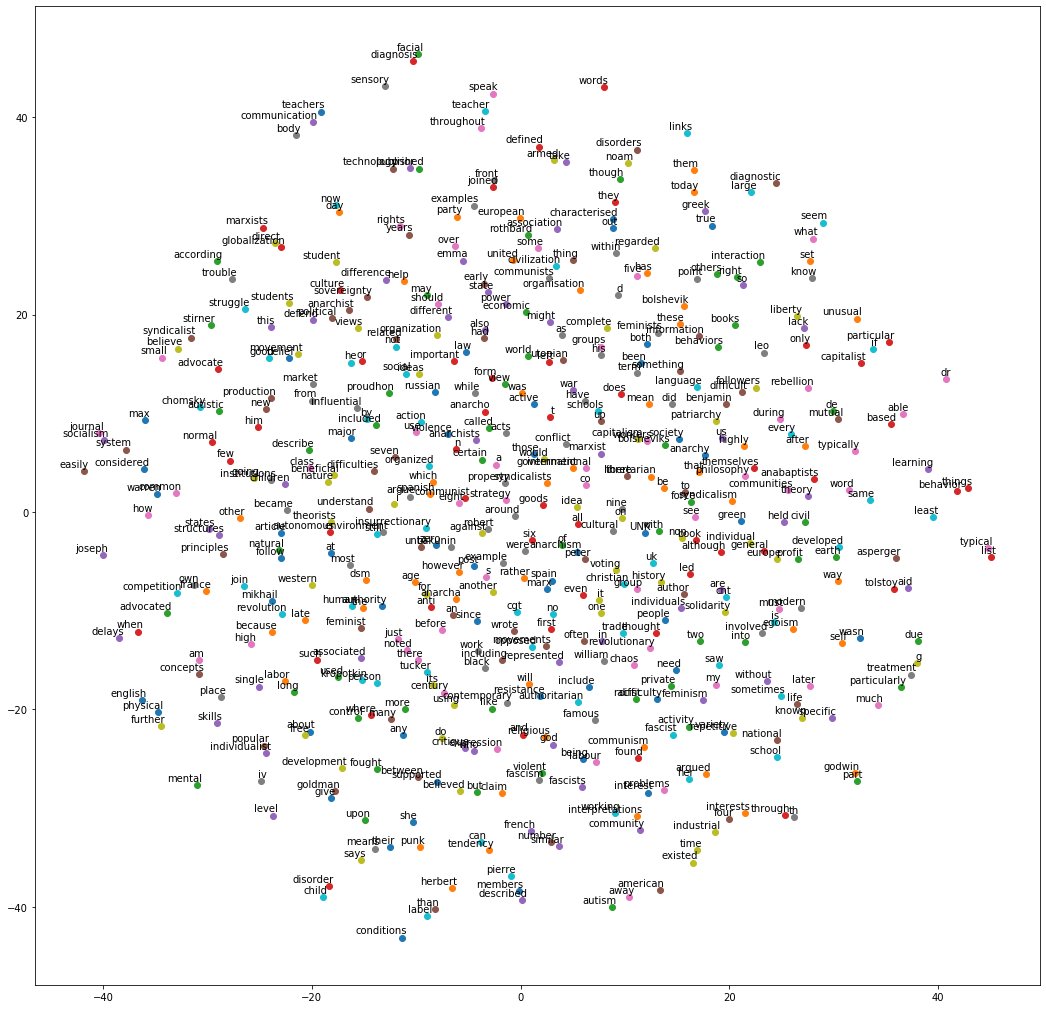

In [7]:
model.visualize()